<a href="https://colab.research.google.com/github/JenBanks8585/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [304]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [305]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

## Wrangle

In [306]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [307]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [308]:
def wrangle(df):
  df['Date']= pd.to_datetime(df['Date'])
  df['Month'] = df['Date'].dt.month
  df['Year'] = df['Date'].dt.year

  df['Great'] = df['Great'].astype(int)

  # Drop some high cardinality categoricals and leakage
  df = df.drop(columns=['Notes',
                        'Location', 
                        'Reviewer', 'Address', 
                        'URL', 
                        'Neighborhood', 
                        'Rec',
                        'overall', 
                        'Date'])
  # Subset
  df = df[['Burrito', 
           'Cost', 
           'Hunger', 
           'Tortilla', 
           'Temp', 
           'Meat', 
           'Fillings',
           'Meat:filling', 
           'Uniformity',
           'Salsa', 
           'Synergy', 
           'Wrap', 
           'Great', 
           'Month', 
           'Year']]


  return df

df = wrangle(df)

In [309]:
print(df.shape)
df.head(2)

(421, 15)


,Burrito,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,Month,Year
0,California,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,1,2016
1,California,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,1,2016


In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Burrito       421 non-null    object 
 1   Cost          414 non-null    float64
 2   Hunger        418 non-null    float64
 3   Tortilla      421 non-null    float64
 4   Temp          401 non-null    float64
 5   Meat          407 non-null    float64
 6   Fillings      418 non-null    float64
 7   Meat:filling  412 non-null    float64
 8   Uniformity    419 non-null    float64
 9   Salsa         396 non-null    float64
 10  Synergy       419 non-null    float64
 11  Wrap          418 non-null    float64
 12  Great         421 non-null    int64  
 13  Month         421 non-null    int64  
 14  Year          421 non-null    int64  
dtypes: float64(11), int64(3), object(1)
memory usage: 52.6+ KB


In [311]:
df.head()

,Burrito,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,Month,Year
0,California,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,1,2016
1,California,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,1,2016
2,Carnitas,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,1,2016
3,Asada,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,1,2016
4,California,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,1,1,2016


### Split into train and val sets

In [312]:
#from sklearn.model_selection import train_test_split
#
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#
#X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [313]:
train = df[df.Year <= 2016]
val = df[df.Year == 2017]
test = df[df.Year >= 2018]
train.shape, val.shape, test.shape

((298, 15), (85, 15), (38, 15))

In [314]:
train.head()

,Burrito,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,Month,Year
0,California,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,1,2016
1,California,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,1,2016
2,Carnitas,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,1,2016
3,Asada,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,1,2016
4,California,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,1,1,2016


### Split TV from FM

In [315]:
target = 'Great'
y_train = train[target]
X_train = train.drop(columns=target)

y_val = val[target]
X_val = val.drop(columns=target)

y_test = test[target]
X_test = test.drop(columns=target)

assert len(y_train) + len(y_val) + len(y_test) == len(y)
assert len(X_train) + len(X_val) + len(X_test) == len(X)

In [316]:
X_train.shape, X_val.shape

((298, 14), (85, 14))

## Establish Baseline

In [317]:
baseline = y_train.value_counts(normalize = True).max()
print(f'Baseline is: {baseline}')

Baseline is: 0.5906040268456376


## Build Logistic Regression Model
Two issues:

- Categorical features that need to be encoded
- Missing values that need to be **imputed**.

In [318]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [319]:
model_log = make_pipeline(
       OneHotEncoder(use_cat_names=True),
       SimpleImputer(),
       StandardScaler(),
       LogisticRegression()
)

model_log.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Check for Metrics

In [320]:
print('Training Accuracy Score:', model_log.score(X_train, y_train))
print('Validation Accuracy Score:', model_log.score(X_val, y_val))
print('Test Accuracy Score:', model_log.score(X_test, y_test))

Training Accuracy Score: 0.889261744966443
Validation Accuracy Score: 0.8117647058823529
Test Accuracy Score: 0.7631578947368421


### Visualize Logistic Regression Results

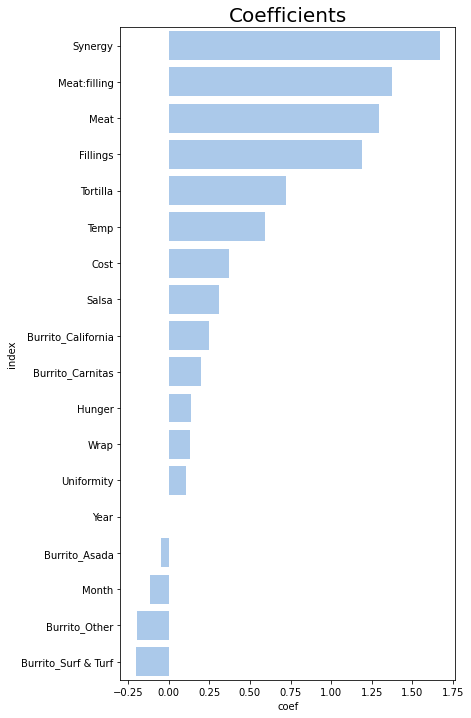

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns

log_coef = model_log.named_steps['logisticregression'].coef_
log_feat = model_log.named_steps['onehotencoder'].get_feature_names()


data1= pd.DataFrame(log_coef[0], log_feat, columns = ['coef'])
data1.reset_index(inplace=True)

f,ax = plt.subplots(figsize=(6,12))

sns.color_palette("bright")
ax.set_title ('Coefficients', fontdict={'size': 20})

sns.barplot(x="coef", y="index", data=data1.sort_values(by = 'coef', ascending = False),
            label="Total", color="b");

In [322]:
len(log_coef[0])

18

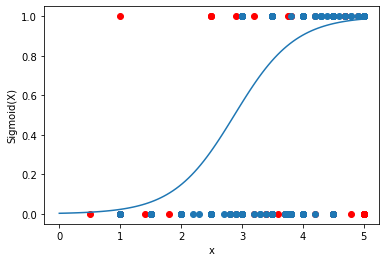

In [323]:
import numpy as np 
import math 
  
x = np.linspace(0, 5, 100) 
z = 1/(1 + 3.5*np.exp(-2*x+4.5)) 
  
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 

plt.scatter(df['Meat:filling'], df['Great'], c='red')  
plt.scatter(df['Synergy'], df['Great'])

plt.show(); 

## Build Linear Regression Model

In [324]:
model_lin = make_pipeline(
       OneHotEncoder(use_cat_names=True),
       SimpleImputer(),
       StandardScaler(),
       LinearRegression()
)

model_lin.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Check for Metrics

In [325]:
from sklearn.metrics import mean_absolute_error, r2_score

print('Training MAE Score:', mean_absolute_error(y_train, model_lin.predict(X_train)))
print('Validation MAE Score:', mean_absolute_error(y_val, model_lin.predict(X_val)))
print('Test MAE Score:', mean_absolute_error(y_test, model_lin.predict(X_test)))

Training MAE Score: 0.28251781432046874
Validation MAE Score: 0.34641193016427546
Test MAE Score: 0.33981082613448865


In [326]:
print('Training R2 Score:', r2_score(y_train, model_lin.predict(X_train)))
print('Validation R2 Score:', r2_score(y_val, model_lin.predict(X_val)))
print('Test R2 Score:', r2_score(y_test, model_lin.predict(X_test)))

Training R2 Score: 0.5454240264407666
Validation R2 Score: 0.4088320969784398
Test R2 Score: 0.3851655428252786


In [327]:
print('Training Accuracy Score:', model_lin.score(X_train, y_train))
print('Validation Accuracy Score:', model_lin.score(X_val, y_val))
print('Test Accuracy Score:', model_lin.score(X_test, y_test))

Training Accuracy Score: 0.5454240264407666
Validation Accuracy Score: 0.40883209697843975
Test Accuracy Score: 0.3851655428252786


### Visualize Coefficients

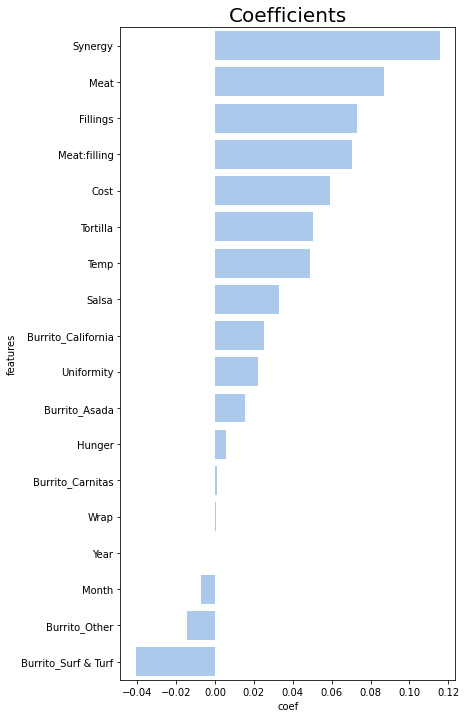

In [328]:
import matplotlib.pyplot as plt
import seaborn as sns

coefficients = model_lin.named_steps['linearregression'].coef_
features = model_lin.named_steps['onehotencoder'].get_feature_names()

data = {'features':features, 'coef': coefficients}
coef_df = pd.DataFrame(data)

f,ax = plt.subplots(figsize=(6,12))

sns.set_color_codes("pastel")
ax.set_title ('Coefficients', fontdict={'size': 20})

sns.barplot(x="coef", y="features", data=coef_df.sort_values(by = 'coef', ascending = False),
            label="Total", color="b");
